#**1. Problem Statement**

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

## **Content**

## **Attributes**



## **People**

ID: Customer's unique identifier

Year_Birth: Customer's birth year

Education: Customer's education level

Marital_Status: Customer's marital status

Income: Customer's yearly household income

Kidhome: Number of children in customer's household

Teenhome: Number of teenagers in customer's household

Dt_Customer: Date of customer's enrollment with the company

Recency: Number of days since customer's last purchase

Complain: 1 if the customer complained in the last 2 years, 0 otherwise



## **Products**

MntWines: Amount spent on wine in last 2 years

MntFruits: Amount spent on fruits in last 2 years

MntMeatProducts: Amount spent on meat in last 2 years

MntFishProducts: Amount spent on fish in last 2 years

MntSweetProducts: Amount spent on sweets in last 2 years

MntGoldProds: Amount spent on gold in last 2 years



## **Promotion**

NumDealsPurchases: Number of purchases made with a discount

AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response: 1 if customer accepted the offer in the last campaign, 0 otherwise



## **Place**

NumWebPurchases: Number of purchases made through the company’s website

NumCatalogPurchases: Number of purchases made using a catalogue

NumStorePurchases: Number of purchases made directly in stores

NumWebVisitsMonth: Number of visits to company’s website in the last month



## **Target**
Need to perform clustering to summarize customer segments.




#  ***2. Basics Of Analysis***

## **2.1 Basic Libraries**

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib.colors import ListedColormap
# Clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics

## **2.2 Import Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

In [62]:
import io
data=pd.read_csv("marketing_campaign.csv",sep='\t')
df=data.copy()
df1=data.copy()

## **2.3 Understanding the Dataset**

In [ ]:
df.head()

In [ ]:
df.info()

We have total 29 columns(variables) in this dataset most of them are int64 datatype, we have 1 float64 and 3 (object type) categorical variables.

Let's check for the null values in the dataset.

# **3. Data Cleaning**

## 3.1 Treat Null Values

In [ ]:
df.isnull().sum()

In [ ]:
df[(df.Income).isnull()==True]

We have 24 null values in the Income column. We can see the NaN in the income column of table above. This Income column is crucial for our analysis so we need to find a way to treat these null values.

Here we are using a way to replace null with some value which we think is more relevant than dropping the records. Calculate the average income based on the education level and replacing it with the null values.

In [8]:
df["avg_income"]=round(df.groupby('Education').Income.transform("mean"),1)
df.Income.fillna(df.avg_income, inplace = True)

In [ ]:
df.isnull().sum().sum()

## 3.2 Check for Duplicate Data

In [ ]:
df.duplicated().sum()

## 3.3 Remove Irrelevent Data

This is also part of data cleaning process where we treat irrelevent data before further analysis.

In [11]:
df['Marital_Status']=df['Marital_Status'].replace(['Absurd','Alone','YOLO'],['Single','Single','Single'])

In [12]:
df['age']=2022-df['Year_Birth']

In [13]:
df['children']=df['Kidhome']+df['Teenhome']

In [14]:
df.drop(['Year_Birth','Kidhome','Teenhome','avg_income'],axis=1,inplace=True)

## 3.4 Feature Engineering 

In [ ]:
df1["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for value in df1["Dt_Customer"]:
    value = value.date()
    dates.append(value)

print("Oldest customer join date: ", min(dates))
print("Newest customer join date:", max(dates))

# Get newest customer date
number_of_days = []
ref_date = max(dates)
for d in dates:
    delta = ref_date - d
    number_of_days.append(delta)

# Create 'Customer_For' feature
df1["Customer_For"] = number_of_days
df1["Customer_For"] = pd.to_numeric(df1["Customer_For"], errors="raise")

Explore unique values in categorical features to get a clearer picture of data.

In [ ]:
print("Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Education:\n", data["Education"].value_counts(), "\n")

##3.5 Further feature engineering

In [17]:
# Age of customers as of 01/11/2021
df1["Age"] = 2021 - df1["Year_Birth"]

# Total amount spend
df1["Spent"] = df1["MntWines"] + df1["MntFruits"] + df1["MntMeatProducts"] + \
    df1["MntFishProducts"] + df1["MntSweetProducts"] + df1["MntGoldProds"]

# Derive household living situation by marital status
df1["Living_With"] = df1["Marital_Status"].replace(
    {"Married": "Partner",
     "Together": "Partner",
     "Absurd": "Alone",
     "Widow": "Alone",
     "YOLO:": "Alone",
     "Divorced": "Alone",
     "Single": "Alone",
     })

# Total children living at home
df1["Children"] = df1["Kidhome"] + df1["Teenhome"]

# Total household members
df1["Family_Size"] = df1["Living_With"].map(
    {"Alone":1,
     "Partner":2}
) + df1["Children"]

# Drop NAs acquired due to failed parsings
df1["Family_Size"].dropna().astype(int)

# Parenthood feature
df1["Is_Parent"] = np.where(df1.Children > 0, 1, 0)

# Divide education levels in three categories
df1["Education"] = df1["Education"].replace(
    {"Basic": "Undergraduate",
     "2n Cycle": "Undergraduate",
     "Graduation": "Graduate",
     "Master": "Postgraduate",
     "PhD": "Postgraduate"}
)

# Improve clarity
df1 = df1.rename(columns={"MntWines": "Wines",
                            "MntFruits": "Fruits",
                            "MntFishProducts": "Fish",
                            "MntSweetProducts": "Sweets",
                            "MntGoldProducts": "Gold"}
                   )

# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue",
           "Year_Birth", "ID"]
df1 = df1.drop(to_drop, axis=1)

In [ ]:
df1.describe()

<Figure size 576x396 with 0 Axes>

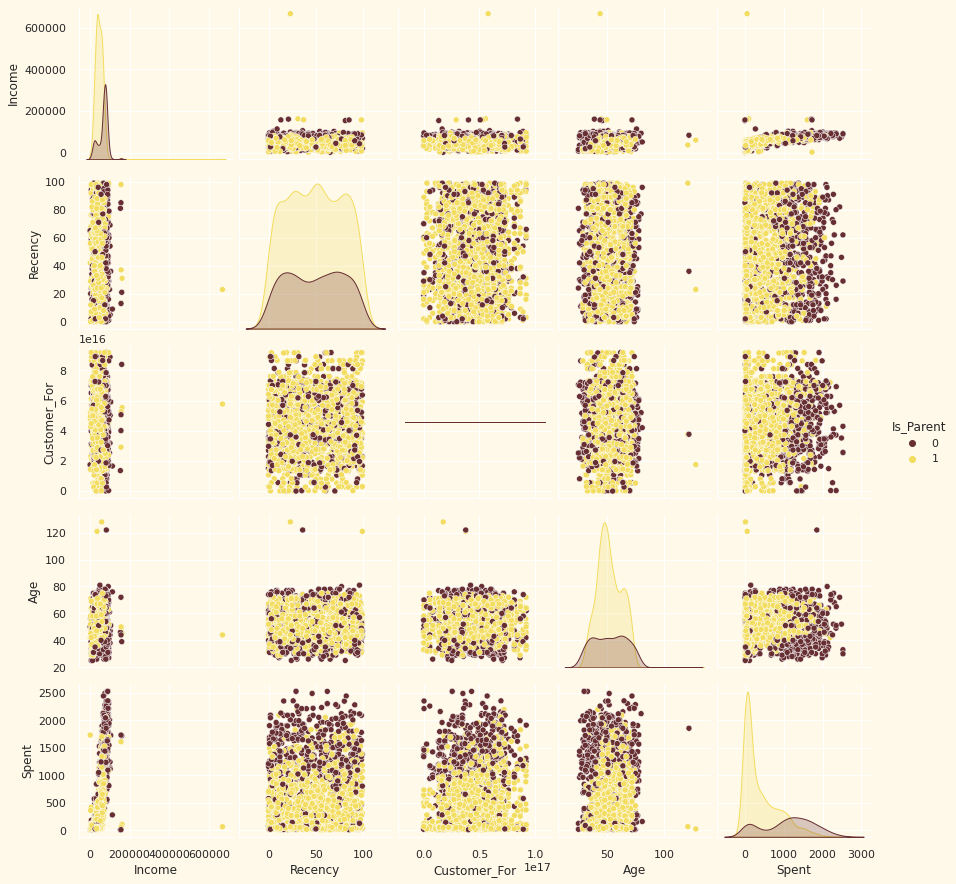

In [19]:
# Plot select features for visual analysis

# Set up colours
sns.set(rc={
    "axes.facecolor":"#FFF9EA",
    "figure.facecolor":"#FFF9EA"
})
pallet = ["#682F33", "#9E713A", "#D3B3B1", "#B9C0C9", "#9F8A78", "#F3DD60"]
cmap = colors.ListedColormap(pallet)

# Plot features
feats = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

plt.figure()
sns.pairplot(df1[feats], hue = "Is_Parent", palette = (["#682F33", "#F3DD60"]))
plt.show()

In [20]:
# Drop outliers by setting limits on Income and Age
df1 = df1[(df1["Age"] < 90)]
df1 = df1[(df1["Income"] < 600000)]

Analysis of correlation amongst features (quantitative attributes only)

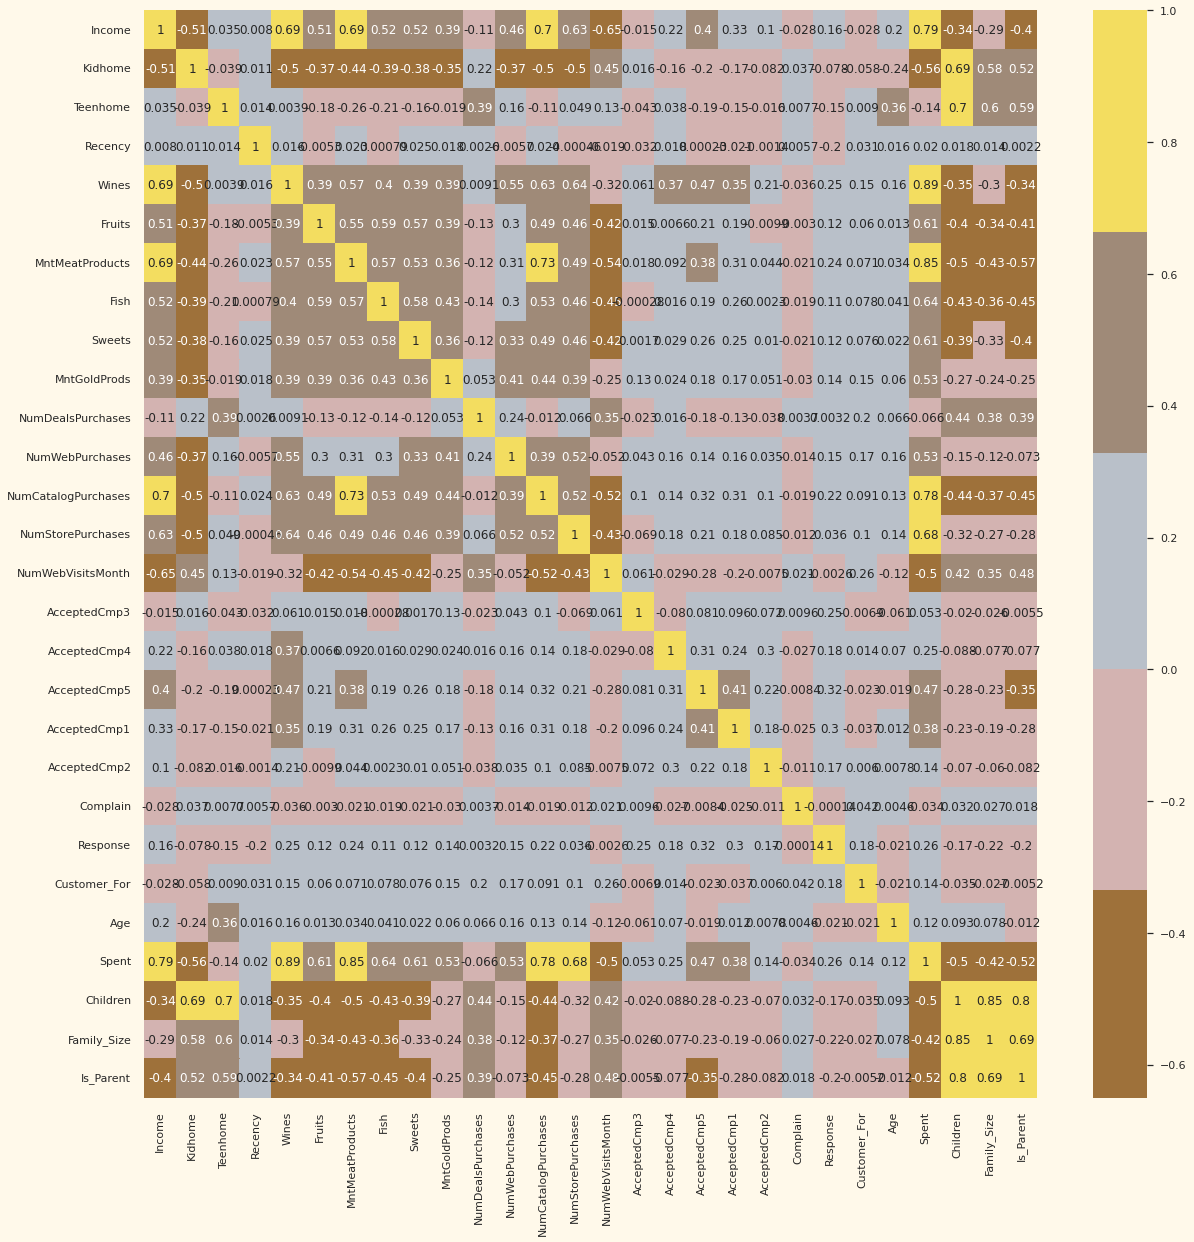

In [21]:
cm_plot = df1.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cm_plot, annot=True, cmap=cmap, center=0)

# **4. Data Preprocessing**

In [ ]:
# Build a list of categorical variables
objs = (df1.dtypes == 'object')
object_cols = list(objs[objs].index)

print("Categorical variables: ", object_cols)

# Label encode object dtypes
LabEnc = LabelEncoder()
for obj in object_cols:
    df1[obj] = df1[[obj]].apply(LabEnc.fit_transform)


All features have been encoded to numerical values.

In [23]:
# Subset dataframe
df1_subset = df1.copy()

cols_delete = ["AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1",
                "AcceptedCmp2", "Complain", "Response"]

df1_subset = df1_subset.drop(cols_delete, axis=1)

# Scale data
scaler = StandardScaler()
scaler.fit(df1_subset)
scaled_df = pd.DataFrame(scaler.transform(df1_subset), columns=df1_subset.columns)

All features have now been scaled.

## Dimensionality Reduction
The final classification to be applied is based on several factors - basically, features. A higher number of features increase the difficulty of implementation. Since many such features are related, many of them are therefore redundant. Therefore, a suitable solution to this is dimensionality reduction on selected features before classification.

Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

A common technique for reducing dimensionality of data sets is Principal Component Analysis (PCA). This technique improves readability with minimal loss of data.

For this data set, the dimensionality will be reduced to 3.

In [ ]:
pca = PCA(n_components=3)
scaled_df.dropna(inplace=True)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1", "col2", "col3"]))
PCA_df.describe().T

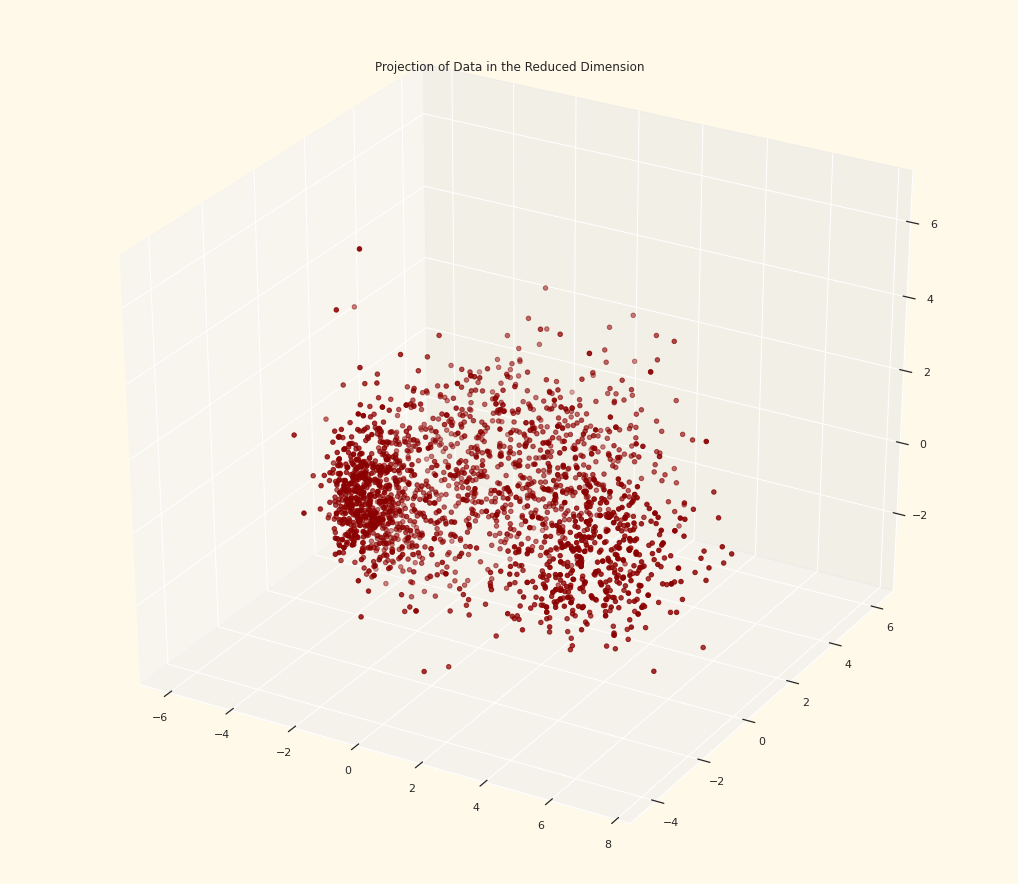

In [25]:
# 3D data visualisation in reduced dimension
x = PCA_df["col1"]
y = PCA_df["col2"]
z = PCA_df["col3"]

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x, y, z, c = "darkred", marker = "o")
ax.set_title("Projection of Data in the Reduced Dimension")
plt.show()

# **5. Exploratory Data Analysis**

Now, we have treated the null values in the dataset. We don't have any missing values in the dataset.

Let's see what we have in the categorical columns.

## 5.1 Categorical Variables

In [ ]:
df.describe(include='object')

In [ ]:
print(df.Education.value_counts())
df.Education.value_counts().plot(kind="bar")

In [ ]:
print(df['Marital_Status'].value_counts())
df['Marital_Status'].value_counts().plot(kind="bar")

## 5.2 Statistical description of continuous variables

In [ ]:
df.describe()

In [ ]:
df[['Income','age','children','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].describe()

This gives a few insights on the population.

Average Income is 52253.6.

Average Age of the population is approx 45 years.

75% of the population has 1 kid and 1 teen at home.

On an average people spend 303 on wine and 167 on meat products.

Average expenses on fruits, fish, sweet and gold are relatively low.

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel='Income'
sns.histplot(data=data,x='Income')
plt.subplot(1,2,2)
plt.xlabel='Income'
sns.boxplot(data=data,x='Income')

This plot shows that variable Income in the dataset has outliers. 

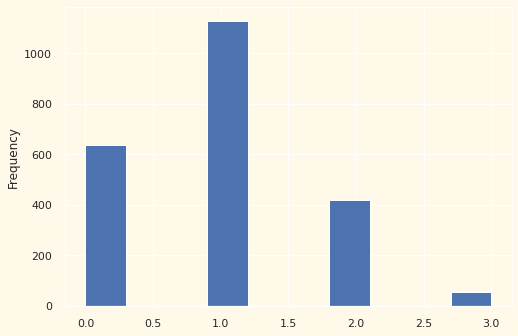

In [32]:
df.children.plot(kind="hist")

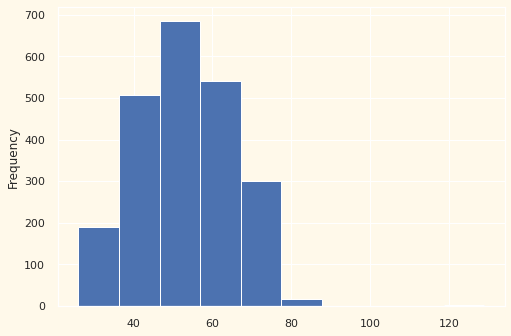

In [33]:
df.age.plot(kind="hist")

This plot on variable Age shows a normal distribution. But we have outliers in this variable too.

## 5.3 Visualization

### 5.3.1 Continuous Variable

Let's visualise all variables. This trick will help us to understand how the variables are skewed or distributed and gives an overall picture of the dataset.

With the help of for loop we can plot all variables in one go rather than plotting each variable at a time.

In [ ]:
df.describe()

In [35]:
cont_col=['Income','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']

In [ ]:
for i in cont_col:
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=data[i],data=df)
    plt.subplot(1,2,2)
    sns.histplot(x=data[i],data=df)
    plt.show()

### 5.3.2 Categorical Variable

In [37]:
cat_col=['Education','Marital_Status']

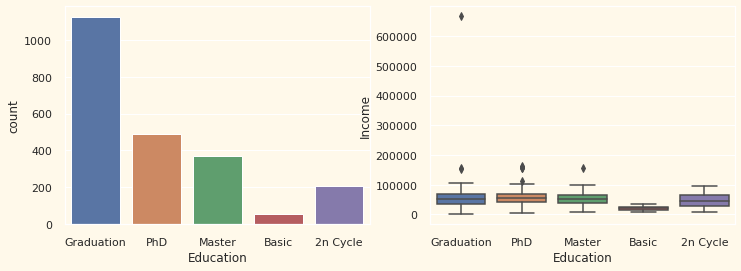

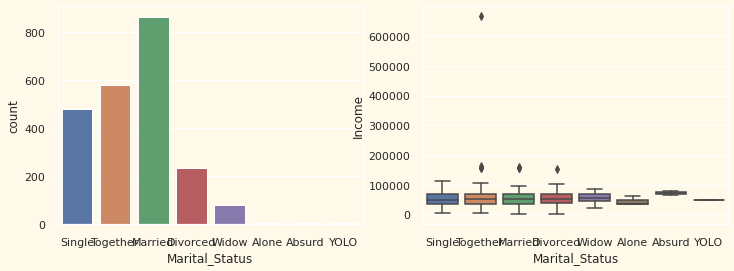

In [38]:
for i in cat_col:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.countplot(x=data[i],data=data)
    plt.subplot(1,2,2)
    sns.boxplot(x =i, y ='Income', data =data)
    plt.show()

So, this is all about the EDA. There is lot more to do as far as EDA is concerned. 

After this is exploration of the dataset, time to proceed for the machine learning algorithm. As our intention is to divide dataset into groups as per the similarity of the observations. These groups are called clusters. To make clusters we are using KMeans clustering algorithm.

# **6. Machine Learning**

To use machine learning we have scikit-learn library. Let's import

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

To proceed with the clustering we need to make another copy of the dataset. This will make the dataset immune to any changes.

In [40]:
cluster=df.copy()

We don't need variables 'ID' and 'Dt_Customer' for clustering so we drop them.

In [41]:
cluster.drop(['ID','Dt_Customer'],axis=1,inplace=True)

Now, we have two categorical variables and they are very important for clustering. We need to convert the variables into numerical codes to convert them into continuous variable. This needs to be done because machine learning doesn't accept categorical variables.

In [42]:
for i in cat_col:
    cluster[i] = cluster[i].astype('category')
    cluster[i] = cluster[i].cat.codes

In [ ]:
cluster.head()

In [ ]:
cluster.info()

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data.

Standard Scaler is a common technique used for standardization of the dataset. There are some manual and libraries available for this in python.

In [45]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(cluster),columns=cluster.columns)

Here we are using KMeans algorithm. For this algorithm to work we need to define number of clusters for it. We need to decide the value of k for KMeans. For deciding the value of K we can use any of two techniques:

~Sum of Squared Errors

~Silhouette Score

### Sum Of Squared Errors

Theoretically, for Kmeans to perform well, we recommend SSE to be minimum. But we generally look out for a elbow shape in the plot of "number of clusters Vs value of SSE".

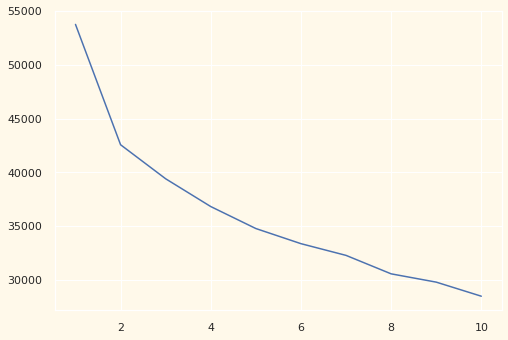

In [46]:
sse={}
for k in range(1,11):
    kmean=KMeans(n_clusters=k,random_state=1).fit(data_scaled)
    lables=kmean.predict(data_scaled)
    sse[k]=kmean.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlable='no. of clusters'
plt.ylable= 'SSE'
plt.show()

As per the plot we select value of 2(number of clusters)

### Silhouette Score

Sometimes we don't get clear indications for the value of K for the algorithm through SSE. In that case we use Silhouette score for the decision of value of K.

Choose value of K at which silhouete score is highest and close to 1.

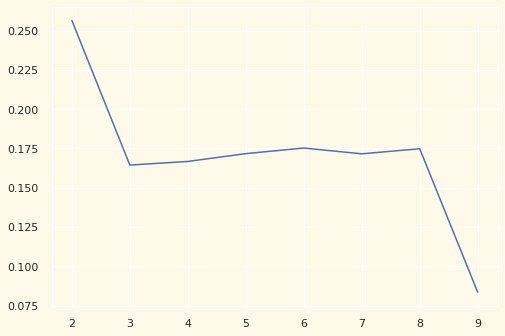

In [47]:
sc={}
for k in range(2,10):
    km=KMeans(n_clusters=k,random_state=1).fit(data_scaled)
    l=km.predict(data_scaled)
    sc[k]=silhouette_score(data_scaled,l)
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlable='no. of clusters'
plt.ylable= 'SSE'
plt.show()

With both the methods, we got 2(number of clusters) as the best value of K for KMeans.

Time to run the algorithm.

In [66]:
kmeans=KMeans(n_clusters=2, random_state=1)
kmeans.fit(data_scaled)
# to predict cluster for each entity of cluster dataset 
cluster['cluster_no']=kmeans.predict(data_scaled) 
# to predict cluster for each entity of original "data" dataset 
data['cluster']=kmeans.predict(data_scaled)

An extra column is added to both datasets copied as well as original.

In [67]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,cluster
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,1
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,3,11,0,1
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,3,11,0,1


In [68]:
data.cluster.value_counts()

1    1390
0     850
Name: cluster, dtype: int64

# **7. Cluster Profiling**

In [69]:
means=data.groupby('cluster').mean()

In [70]:
df_mean=pd.DataFrame(means)
df_mean.index=['cluster1','cluster2']
df_mean.T

,cluster1,cluster2
ID,5611.558824,5580.297122
Year_Birth,1967.130588,1969.830216
Income,72825.807601,39636.520378
Kidhome,0.071765,0.671942
Teenhome,0.394118,0.574820
Recency,49.428235,48.914388
MntWines,609.971765,116.791367
MntFruits,57.975294,6.933813
MntMeatProducts,374.311765,40.146043
MntFishProducts,82.264706,10.166906


In [72]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,cluster
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,1
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,3,11,0,1
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,3,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,0,0,0,0,0,0,3,11,0,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,0,0,0,1,0,0,3,11,0,1
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,0,1,0,0,0,0,3,11,0,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,0,0,0,0,0,0,3,11,0,0


In [71]:
cluster1=data.loc[data.cluster==0]
cluster2=data.loc[data.cluster==1]

In [ ]:
cluster1

Graduation    454
PhD           198
Master        127
2n Cycle       70
Basic           1
Name: Education, dtype: int64
Graduation    673
PhD           288
Master        243
2n Cycle      133
Basic          53
Name: Education, dtype: int64


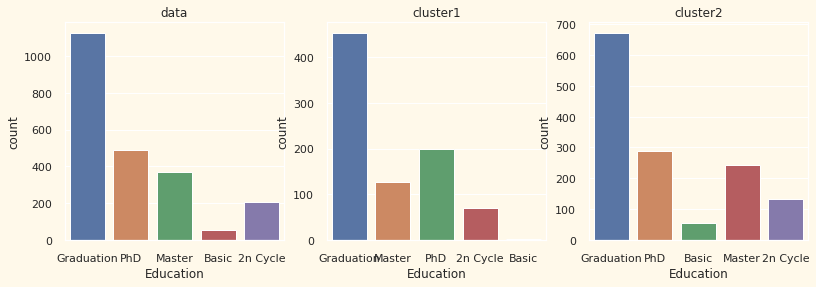

Married     318
Together    215
Single      182
Divorced     95
Widow        38
Absurd        2
Name: Marital_Status, dtype: int64
Married     546
Together    365
Single      298
Divorced    137
Widow        39
Alone         3
YOLO          2
Name: Marital_Status, dtype: int64


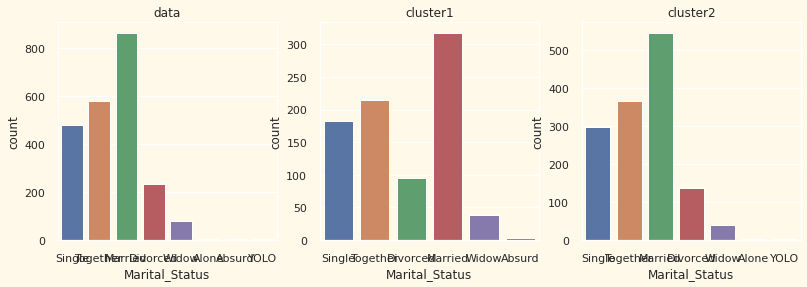

In [73]:
for i in cat_col:
    print(cluster1[i].value_counts())
    print(cluster2[i].value_counts())
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1)
    plt.title("data")
    sns.countplot(x=data[i],data=data)
    plt.subplot(1,4,2)
    plt.title("cluster1")
    sns.countplot(x=cluster1[i],data=cluster1)
    plt.subplot(1,4,3)
    plt.title("cluster2")
    sns.countplot(x=cluster2[i],data=cluster2)
    plt.show()

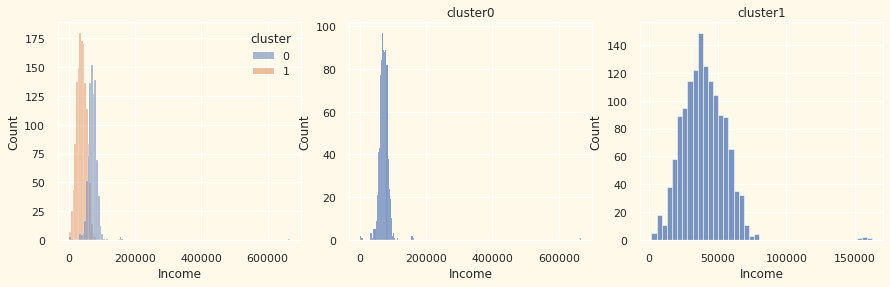

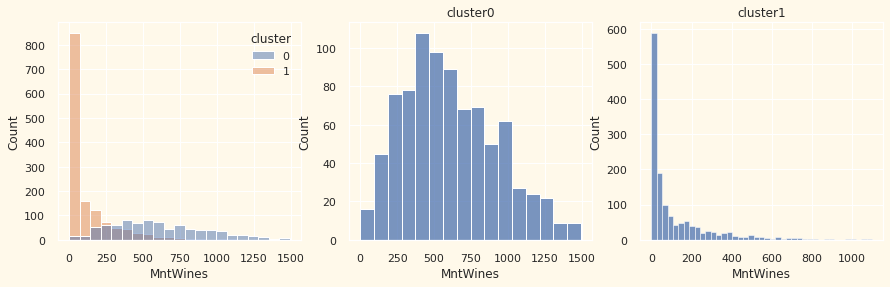

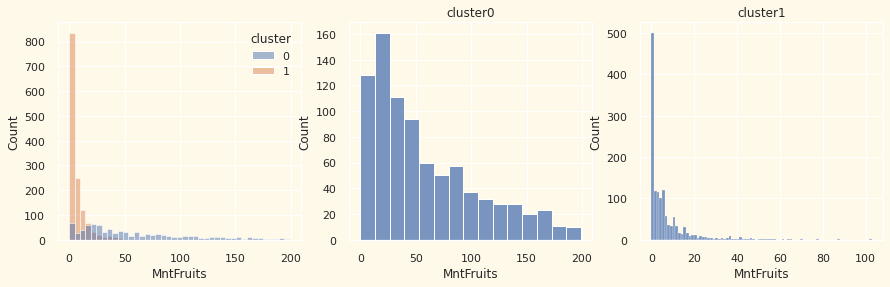

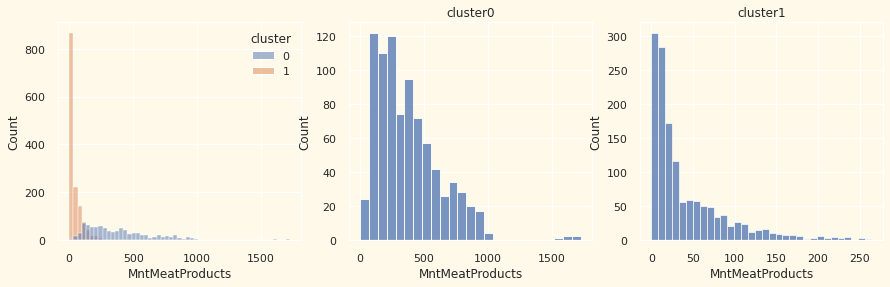

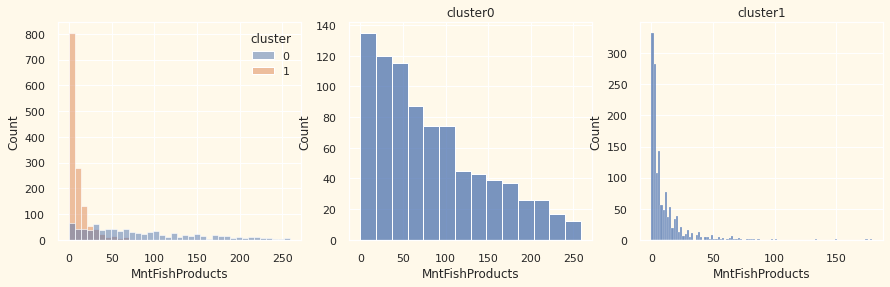

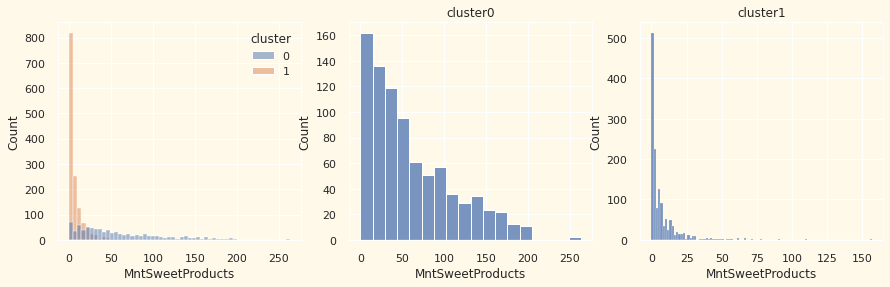

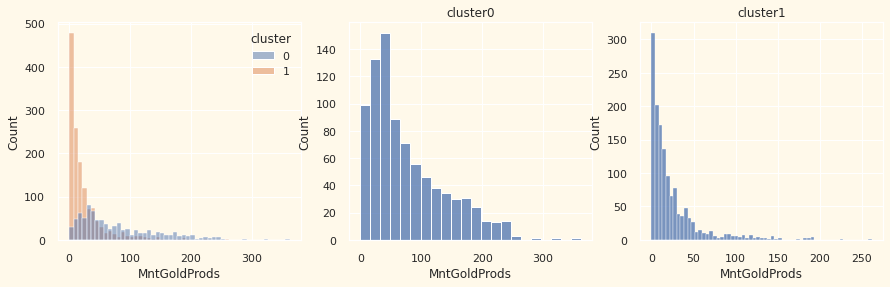

In [57]:
for i in cont_col:
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    sns.histplot(x=data[i],data=data,hue='cluster')
    plt.subplot(1,4,2)
    plt.title("cluster0")
    sns.histplot(x=cluster1[i],data=cluster1)
    plt.subplot(1,4,3)
    plt.title("cluster1")
    sns.histplot(x=cluster2[i],data=cluster2)
    plt.show()

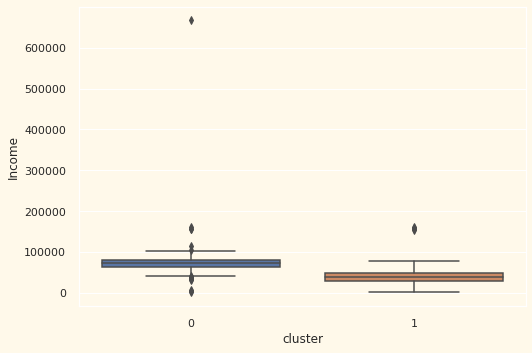

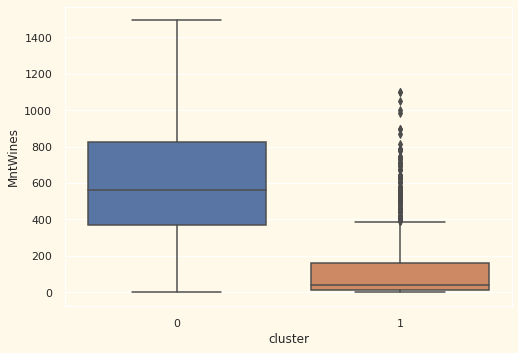

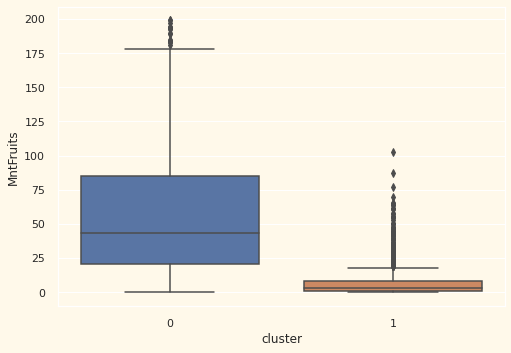

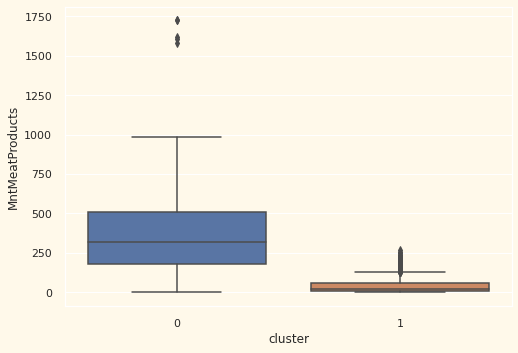

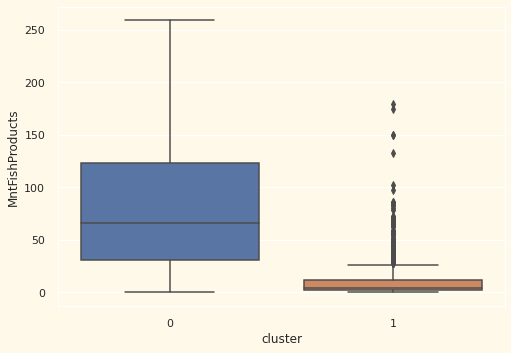

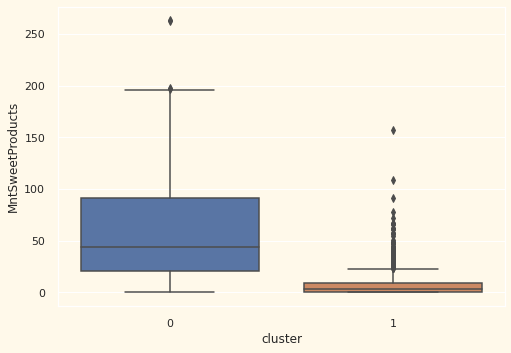

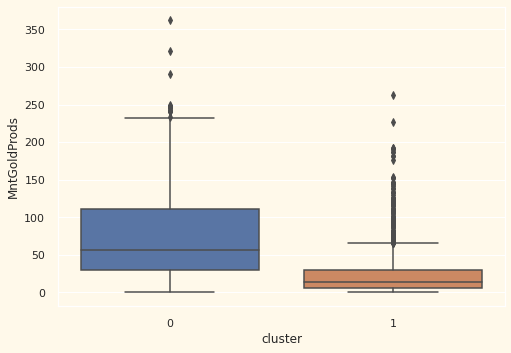

In [58]:
for i in cont_col:
    sns.boxplot(x='cluster', y=i, data=data)
    plt.show()

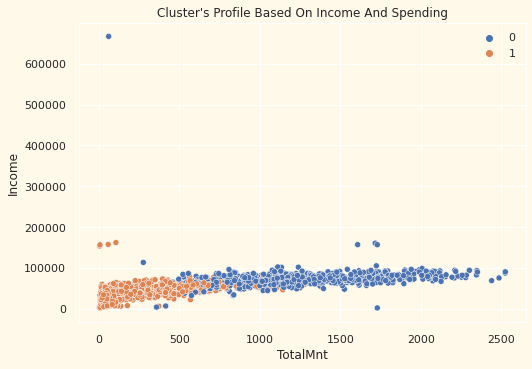

In [74]:
#created a column showing the total amount a customer spent
df1['TotalMnt'] = df1.MntMeatProducts + df1. MntWines + df1.MntFruits + df1.MntFishProducts + df1.MntSweetProducts + df1.MntGoldProds

#checks how much of a customer's income is spent purchasing these products
df1['Income_to_spend'] = round(df1['TotalMnt']/df1['Income'],3)
#check if there is a clear distinction between clusters with reference to income and total amount spent
pl = sns.scatterplot(data = df1,x=df1["TotalMnt"], y=df1["Income"],hue=data["cluster"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()